In [26]:
import pandas as pd
import numpy as np
from scipy.stats import kruskal, mannwhitneyu
from scipy import stats
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
snp = pd.read_csv("/Users/luasoares/DOC/COMPARE/02_RefGeno_analysis/00_RESULTADOS/vcf_count_miss9.txt", index_col=1)

In [16]:
snp

,VCF_File,ReferenceGenome,Missing,SNP_Count
0,alt80,03_aaxi,miss9,12933
1,alt80,02_axi,miss9,12960
2,alt80,06_habro,miss9,1285
3,alt80,01_infl,miss9,13379
4,alt80,05_nico,miss9,1754
5,alt80,04_secr,miss9,11875
6,grp41,03_aaxi,miss9,3875
7,grp41,02_axi,miss9,3894
8,grp41,06_habro,miss9,562
9,grp41,01_infl,miss9,3867


In [17]:
snp = snp.drop(columns="Missing")

In [21]:
print("Data structure:")
print(snp)
print("\nSummary statistics:")
print(snp.describe())

Data structure:
   VCF_File ReferenceGenome  SNP_Count
0     alt80         03_aaxi      12933
1     alt80          02_axi      12960
2     alt80        06_habro       1285
3     alt80         01_infl      13379
4     alt80         05_nico       1754
5     alt80         04_secr      11875
6     grp41         03_aaxi       3875
7     grp41          02_axi       3894
8     grp41        06_habro        562
9     grp41         01_infl       3867
10    grp41         05_nico        723
11    grp41         04_secr       3581
12    phylo         03_aaxi       5316
13    phylo          02_axi       5301
14    phylo        06_habro       1209
15    phylo         01_infl       4971
16    phylo         05_nico       1615
17    phylo         04_secr       4853
18    alt80          denovo       4175
19    grp41          denovo         45
20    phylo          denovo       3575

Summary statistics:
          SNP_Count
count     21.000000
mean    4845.142857
std     4270.142109
min       45.000000
25%  

In [22]:
# 1. FRIEDMAN TEST (best for this design - repeated measures across genomes)
# This tests if SNP counts differ across reference genomes,
# accounting for the fact that the same VCF files are used across genomes
print("\n" + "=" * 80)
print("FRIEDMAN TEST")
print("Tests if SNP counts differ across reference genomes (repeated measures)")
print("=" * 80)

# Pivot data for Friedman test (each row = VCF file, columns = genomes)
pivot_snp = snp.pivot(index='VCF_File', columns='ReferenceGenome', values='SNP_Count')
print("\nPivoted data:")
print(pivot_snp)


FRIEDMAN TEST
Tests if SNP counts differ across reference genomes (repeated measures)

Pivoted data:
ReferenceGenome  01_infl  02_axi  03_aaxi  04_secr  05_nico  06_habro  denovo
VCF_File                                                                     
alt80              13379   12960    12933    11875     1754      1285    4175
grp41               3867    3894     3875     3581      723       562      45
phylo               4971    5301     5316     4853     1615      1209    3575


In [43]:
import statsmodels.api as sm

ModuleNotFoundError: No module named 'statsmodels'

In [44]:
import pandas as pd
import numpy as np
from scipy.stats import friedmanchisquare, wilcoxon
from statsmodels.stats.multitest import multipletests

# Assuming you already have pivot_snp from your Friedman test
print("\n" + "=" * 80)
print("POST-HOC ANALYSIS: Pairwise Wilcoxon Signed-Rank Tests")
print("=" * 80)

# 1. Get all possible pairwise combinations of genomes
genomes = pivot_snp.columns.tolist()
pairs = []
for i in range(len(genomes)):
    for j in range(i + 1, len(genomes)):
        pairs.append((genomes[i], genomes[j]))

# 2. Perform pairwise Wilcoxon signed-rank tests
posthoc_results = []

for genome1, genome2 in pairs:
    # Remove NaN values (in case some VCF files are missing data)
    data1 = pivot_snp[genome1].dropna()
    data2 = pivot_snp[genome2].dropna()
    
    # Ensure we're comparing the same VCF files
    common_idx = data1.index.intersection(data2.index)
    data1_common = data1.loc[common_idx]
    data2_common = data2.loc[common_idx]
    
    if len(data1_common) > 0:
        # Perform Wilcoxon signed-rank test
        stat, p_value = wilcoxon(data1_common, data2_common)
        
        posthoc_results.append({
            'pair': f"{genome1} vs {genome2}",
            'genome1': genome1,
            'genome2': genome2,
            'n_pairs': len(data1_common),
            'median1': np.median(data1_common),
            'median2': np.median(data2_common),
            'mean1': np.mean(data1_common),
            'mean2': np.mean(data2_common),
            'wilcoxon_statistic': stat,
            'p_value': p_value
        })

# Convert to DataFrame
posthoc_mapping = pd.DataFrame(posthoc_results)

# 3. Apply multiple testing correction
p_values = posthoc_mapping['p_value'].values
rejected, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')

posthoc_mapping['p_value_corrected'] = pvals_corrected
posthoc_mapping['significant'] = rejected

# 4. Display results
print("\nPOST-HOC RESULTS:")
print("=" * 50)

significant_pairs = posthoc_mapping[posthoc_mapping['significant']]
non_significant_pairs = posthoc_mapping[~posthoc_df['significant']]

if len(significant_pairs) > 0:
    print("\nSIGNIFICANT PAIRS (after FDR correction):")
    for _, row in significant_pairs.iterrows():
        print(f"  {row['pair']}: p = {row['p_value']:.4f}, p_corrected = {row['p_value_corrected']:.4f}")
        print(f"    Medians: {row['genome1']} = {row['median1']:.1f}, {row['genome2']} = {row['median2']:.1f}")

if len(non_significant_pairs) > 0:
    print("\nNON-SIGNIFICANT PAIRS:")
    for _, row in non_significant_pairs.iterrows():
        print(f"  {row['pair']}: p = {row['p_value']:.4f}, p_corrected = {row['p_value_corrected']:.4f}")

# 5. Summary statistics
print("\n" + "=" * 50)
print("SUMMARY STATISTICS:")
print(f"Total comparisons: {len(posthoc_df)}")
print(f"Significant comparisons: {len(significant_pairs)}")
print(f"Non-significant comparisons: {len(non_significant_pairs)}")

# 6. Optional: Create a compact matrix view
print("\n" + "=" * 50)
print("COMPACT MATRIX VIEW:")
print("(* = significant difference)")

# Create a simple matrix representation
genomes_sorted = sorted(genomes)
matrix_df = pd.DataFrame(index=genomes_sorted, columns=genomes_sorted)

for _, row in posthoc_df.iterrows():
    g1, g2 = row['genome1'], row['genome2']
    if row['significant']:
        matrix_df.loc[g1, g2] = '*'
        matrix_df.loc[g2, g1] = '*'
    else:
        matrix_df.loc[g1, g2] = 'ns'
        matrix_df.loc[g2, g1] = 'ns'

np.fill_diagonal(matrix_df.values, '-')
print(matrix_df)


POST-HOC ANALYSIS: Pairwise Wilcoxon Signed-Rank Tests

POST-HOC RESULTS:

NON-SIGNIFICANT PAIRS:
  01_infl vs 02_axi: p = 1.0000, p_corrected = 1.0000
  01_infl vs 03_aaxi: p = 1.0000, p_corrected = 1.0000
  01_infl vs 04_secr: p = 0.2500, p_corrected = 0.3281
  01_infl vs 05_nico: p = 0.2500, p_corrected = 0.3281
  01_infl vs 06_habro: p = 0.2500, p_corrected = 0.3281
  01_infl vs denovo: p = 0.2500, p_corrected = 0.3281
  02_axi vs 03_aaxi: p = 0.5000, p_corrected = 0.5526
  02_axi vs 04_secr: p = 0.2500, p_corrected = 0.3281
  02_axi vs 05_nico: p = 0.2500, p_corrected = 0.3281
  02_axi vs 06_habro: p = 0.2500, p_corrected = 0.3281
  02_axi vs denovo: p = 0.2500, p_corrected = 0.3281
  03_aaxi vs 04_secr: p = 0.2500, p_corrected = 0.3281
  03_aaxi vs 05_nico: p = 0.2500, p_corrected = 0.3281
  03_aaxi vs 06_habro: p = 0.2500, p_corrected = 0.3281
  03_aaxi vs denovo: p = 0.2500, p_corrected = 0.3281
  04_secr vs 05_nico: p = 0.2500, p_corrected = 0.3281
  04_secr vs 06_habro: p = 

In [45]:
# You can try different correction methods:
correction_methods = ['bonferroni', 'fdr_bh', 'holm', 'sidak']

for method in correction_methods:
    print(f"\n--- Correction method: {method.upper()} ---")
    rejected, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method=method)
    
    sig_count = sum(rejected)
    print(f"Significant pairs: {sig_count}/{len(p_values)}")
    
    # Show a few significant pairs if any
    if sig_count > 0:
        sig_indices = np.where(rejected)[0]
        for idx in sig_indices[:3]:  # Show first 3
            pair = posthoc_df.iloc[idx]
            print(f"  {pair['pair']}: p_corrected = {pvals_corrected[idx]:.4f}")


--- Correction method: BONFERRONI ---
Significant pairs: 0/21

--- Correction method: FDR_BH ---
Significant pairs: 0/21

--- Correction method: HOLM ---
Significant pairs: 0/21

--- Correction method: SIDAK ---
Significant pairs: 0/21


/Users/luasoares/Library/Python/3.9/lib/python/site-packages/statsmodels/stats/multitest.py:164: RuntimeWarning: divide by zero encountered in log1p
  pvals_corrected = -np.expm1(ntests * np.log1p(-pvals))


In [39]:
# 3. POST-HOC PAIRWISE COMPARISONS (Wilcoxon Signed-Rank Test for paired data)
print("\n" + "=" * 80)
print("POST-HOC PAIRWISE COMPARISONS (Wilcoxon Signed-Rank Test)")
print("Compares each pair of reference genomes")
print("=" * 80)

from scipy.stats import wilcoxon

posthoc_results = []
for g1, g2 in combinations(all_genomes, 2):
    if g1 in pivot_snp.columns and g2 in pivot_snp.columns:
        counts1 = pivot_snp[g1].dropna()
        counts2 = pivot_snp[g2].dropna()
        
        # Only compare if we have paired data
        common_idx = counts1.index.intersection(counts2.index)
        if len(common_idx) >= 2:
            c1 = pivot_snp.loc[common_idx, g1]
            c2 = pivot_snp.loc[common_idx, g2]
            
            stat, p_value = wilcoxon(c1, c2)
            
            posthoc_results.append({
                'Genome1': g1,
                'Genome2': g2,
                'n_pairs': len(common_idx),
                'median_diff': np.median(c1 - c2),
                'statistic': stat,
                'p_value': p_value,
                'significant': 'Yes' if p_value < 0.05 else 'No'
            })

posthoc_df = pd.DataFrame(posthoc_results)
print(posthoc_df)
print("\nSignificant pairwise differences:")
print(posthoc_df[posthoc_df['significant'] == 'Yes'])



POST-HOC PAIRWISE COMPARISONS (Wilcoxon Signed-Rank Test)
Compares each pair of reference genomes
     Genome1   Genome2  n_pairs  median_diff  statistic  p_value significant
0    01_infl    02_axi        3        -27.0        3.0     1.00          No
1    01_infl   03_aaxi        3         -8.0        3.0     1.00          No
2    01_infl   04_secr        3        286.0        0.0     0.25          No
3    01_infl   05_nico        3       3356.0        0.0     0.25          No
4    01_infl  06_habro        3       3762.0        0.0     0.25          No
5    01_infl    denovo        3       3822.0        0.0     0.25          No
6     02_axi   03_aaxi        3         19.0        1.0     0.50          No
7     02_axi   04_secr        3        448.0        0.0     0.25          No
8     02_axi   05_nico        3       3686.0        0.0     0.25          No
9     02_axi  06_habro        3       4092.0        0.0     0.25          No
10    02_axi    denovo        3       3849.0        0.

In [37]:
kw_df

,VCF_File,n_genomes,H_statistic,p_value,significant
0,alt80,7,6.0,0.42319,No
1,grp41,7,6.0,0.42319,No
2,phylo,7,6.0,0.42319,No


# Mapping

In [48]:
mapping = pd.read_csv("/Users/luasoares/DOC/COMPARE/02_RefGeno_analysis/05_MAPPING/porcent_mapping_genomes.txt", sep = "\t")
mapping

,Samples,Grupo,P.axillaris II,P.axillaris I,P.inflata,P.secreta,N.sylvestris,S. habrochaites
0,1_Palti320_R,alt80,0.87,0.87,0.91,0.88,0.35,0.28
1,2_Palti321_R,alt80,0.86,0.86,0.90,0.86,0.36,0.28
2,3_Palti323_R,alt80,0.86,0.86,0.90,0.86,0.38,0.30
3,4_Palti325_R,alt80,0.87,0.87,0.91,0.87,0.34,0.27
4,5_Palti330_S,alt80,0.81,0.81,0.85,0.82,0.37,0.30
...,...,...,...,...,...,...,...,...
145,146_send114,phylo,0.72,0.72,0.73,0.72,0.45,0.38
146,147_send117,phylo,0.62,0.63,0.63,0.63,0.38,0.31
147,148_send121,phylo,0.76,0.76,0.77,0.76,0.48,0.41
148,149_send54,phylo,0.74,0.74,0.75,0.74,0.45,0.38


In [49]:
mapping_long = mapping.melt(id_vars=['Samples', 'Grupo'], 
                    var_name='ReferenceGenome', 
                    value_name='MappingRate')
mapping_long

,Samples,Grupo,ReferenceGenome,MappingRate
0,1_Palti320_R,alt80,P.axillaris II,0.87
1,2_Palti321_R,alt80,P.axillaris II,0.86
2,3_Palti323_R,alt80,P.axillaris II,0.86
3,4_Palti325_R,alt80,P.axillaris II,0.87
4,5_Palti330_S,alt80,P.axillaris II,0.81
...,...,...,...,...
895,146_send114,phylo,S. habrochaites,0.38
896,147_send117,phylo,S. habrochaites,0.31
897,148_send121,phylo,S. habrochaites,0.41
898,149_send54,phylo,S. habrochaites,0.38


In [50]:
print("Data shape:", mapping_long.shape)
print("\nGroup counts:")
print(mapping_long['Grupo'].value_counts())
print("\nReference genome counts:")
print(mapping_long['ReferenceGenome'].value_counts())

Data shape: (900, 4)

Group counts:
Grupo
alt80    480
grp41    246
phylo    174
Name: count, dtype: int64

Reference genome counts:
ReferenceGenome
P.axillaris II     150
P.axillaris I      150
P.inflata          150
P.secreta          150
N.sylvestris       150
S. habrochaites    150
Name: count, dtype: int64


In [51]:
def check_normality_comprehensive(df, group_col, value_col, group_name):
    """Comprehensive normality checking for a specific group"""
    group_data = df[df[group_col] == group_name]
    
    print(f"\n{'='*60}")
    print(f"NORMALITY ANALYSIS FOR GROUP: {group_name}")
    print(f"{'='*60}")
    
    # Test for each reference genome
    genomes = group_data['ReferenceGenome'].unique()
    
    normality_results = []
    
    for genome in genomes:
        data = group_data[group_data['ReferenceGenome'] == genome][value_col].dropna()
        
        if len(data) < 3:
            print(f"  {genome}: Insufficient data (n={len(data)})")
            continue
            
        # Statistical tests
        shapiro_stat, shapiro_p = shapiro(data)
        dagostino_stat, dagostino_p = normaltest(data)
        
        # Additional test: Kolmogorov-Smirnov
        ks_stat, ks_p = stats.kstest(data, 'norm', args=(np.mean(data), np.std(data, ddof=1)))
        
        # Skewness and Kurtosis
        skewness = stats.skew(data)
        kurtosis = stats.kurtosis(data)
        
        normality_results.append({
            'group': group_name,
            'genome': genome,
            'n': len(data),
            'mean': np.mean(data),
            'std': np.std(data),
            'shapiro_p': shapiro_p,
            'dagostino_p': dagostino_p,
            'ks_p': ks_p,
            'skewness': skewness,
            'kurtosis': kurtosis,
            'is_normal_shapiro': shapiro_p > 0.05,
            'is_normal_dagostino': dagostino_p > 0.05
        })
        
        print(f"\n  {genome} (n={len(data)}):")
        print(f"    Shapiro-Wilk: p = {shapiro_p:.4f} {'(normal)' if shapiro_p > 0.05 else '(NOT normal)'}")
        print(f"    D'Agostino: p = {dagostino_p:.4f} {'(normal)' if dagostino_p > 0.05 else '(NOT normal)'}")
        print(f"    Skewness: {skewness:.3f} ({'moderate' if abs(skewness) < 1 else 'strong'})")
        print(f"    Kurtosis: {kurtosis:.3f}")
    
    return pd.DataFrame(normality_results)

# Check normality for each group
groups = mapping_long['Grupo'].unique()
all_normality_results = []

for group in groups:
    results_df = check_normality_comprehensive(mapping_long, 'Grupo', 'MappingRate', group)
    all_normality_results.append(results_df)

normality_summary = pd.concat(all_normality_results, ignore_index=True)


NORMALITY ANALYSIS FOR GROUP: alt80

  P.axillaris II (n=80):
    Shapiro-Wilk: p = 0.0000 (NOT normal)
    D'Agostino: p = 0.0000 (NOT normal)
    Skewness: -2.663 (strong)
    Kurtosis: 9.826

  P.axillaris I (n=80):
    Shapiro-Wilk: p = 0.0000 (NOT normal)
    D'Agostino: p = 0.0000 (NOT normal)
    Skewness: -2.692 (strong)
    Kurtosis: 10.091

  P.inflata (n=80):
    Shapiro-Wilk: p = 0.0000 (NOT normal)
    D'Agostino: p = 0.0000 (NOT normal)
    Skewness: -2.637 (strong)
    Kurtosis: 9.642

  P.secreta (n=80):
    Shapiro-Wilk: p = 0.0000 (NOT normal)
    D'Agostino: p = 0.0000 (NOT normal)
    Skewness: -2.674 (strong)
    Kurtosis: 10.090

  N.sylvestris (n=80):
    Shapiro-Wilk: p = 0.2863 (normal)
    D'Agostino: p = 0.0978 (normal)
    Skewness: -0.489 (moderate)
    Kurtosis: 0.446

  S. habrochaites (n=80):
    Shapiro-Wilk: p = 0.2595 (normal)
    D'Agostino: p = 0.2343 (normal)
    Skewness: -0.412 (moderate)
    Kurtosis: 0.159

NORMALITY ANALYSIS FOR GROUP: grp41


/Users/luasoares/Library/Python/3.9/lib/python/site-packages/scipy/stats/_ksstats.py:165: RuntimeWarning: divide by zero encountered in matmul
  H = np.matmul(H, H)
/Users/luasoares/Library/Python/3.9/lib/python/site-packages/scipy/stats/_ksstats.py:165: RuntimeWarning: overflow encountered in matmul
  H = np.matmul(H, H)
/Users/luasoares/Library/Python/3.9/lib/python/site-packages/scipy/stats/_ksstats.py:165: RuntimeWarning: invalid value encountered in matmul
  H = np.matmul(H, H)
/Users/luasoares/Library/Python/3.9/lib/python/site-packages/scipy/stats/_ksstats.py:163: RuntimeWarning: divide by zero encountered in matmul
  Hpwr = np.matmul(Hpwr, H)
/Users/luasoares/Library/Python/3.9/lib/python/site-packages/scipy/stats/_ksstats.py:163: RuntimeWarning: overflow encountered in matmul
  Hpwr = np.matmul(Hpwr, H)
/Users/luasoares/Library/Python/3.9/lib/python/site-packages/scipy/stats/_ksstats.py:163: RuntimeWarning: invalid value encountered in matmul
  Hpwr = np.matmul(Hpwr, H)


In [52]:
normality_summary

,group,genome,n,mean,std,shapiro_p,dagostino_p,ks_p,skewness,kurtosis,is_normal_shapiro,is_normal_dagostino
0,alt80,P.axillaris II,80,0.823750,0.066584,9.516652e-11,1.388866e-15,0.001225,-2.663326,9.825887,False,False
1,alt80,P.axillaris I,80,0.822625,0.065988,1.006476e-10,8.867385e-16,0.000742,-2.692154,10.091110,False,False
2,alt80,P.inflata,80,0.861875,0.068321,1.065622e-10,2.002563e-15,0.000757,-2.637241,9.641985,False,False
3,alt80,P.secreta,80,0.825000,0.066427,1.904636e-10,1.035073e-15,0.000851,-2.673805,10.090316,False,False
4,alt80,N.sylvestris,80,0.334250,0.052124,2.862901e-01,9.777864e-02,0.647666,-0.489469,0.445610,True,True
5,alt80,S. habrochaites,80,0.263875,0.043689,2.595017e-01,2.342870e-01,0.464186,-0.412332,0.159430,True,True
6,grp41,P.axillaris II,41,0.850732,0.052050,7.965926e-05,8.176528e-06,0.446919,-1.657464,3.302095,False,False
7,grp41,P.axillaris I,41,0.850732,0.052003,7.422107e-05,7.613893e-06,0.446323,-1.666037,3.318613,False,False
8,grp41,P.inflata,41,0.881951,0.053975,2.717655e-05,1.700441e-06,0.293832,-1.813182,3.853732,False,False
9,grp41,P.secreta,41,0.852927,0.051714,3.916620e-05,3.373678e-06,0.199851,-1.739171,3.639933,False,False


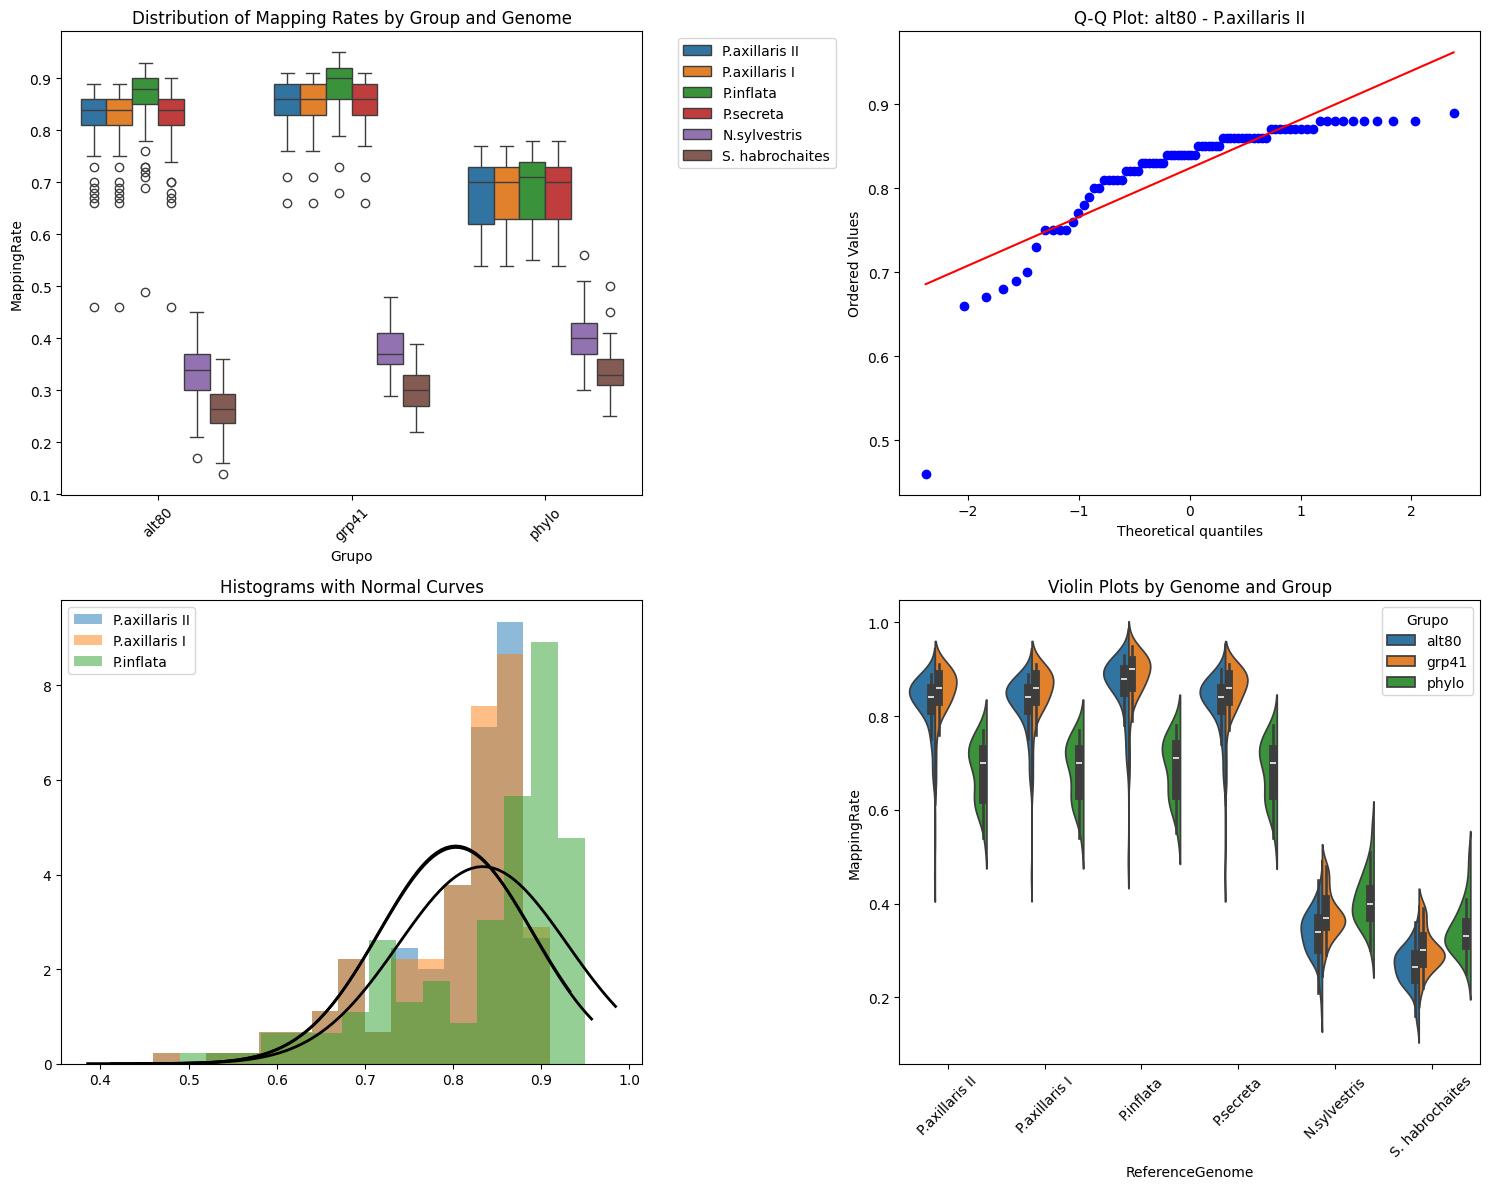

In [53]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Boxplots by group and genome
plt.sca(axes[0, 0])
sns.boxplot(data=mapping_long, x='Grupo', y='MappingRate', hue='ReferenceGenome')
plt.title('Distribution of Mapping Rates by Group and Genome')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 2. Q-Q plots for a sample group and genome
plt.sca(axes[0, 1])
sample_data = mapping_long[
    (mapping_long['Grupo'] == groups[0]) & 
    (mapping_long['ReferenceGenome'] == mapping_long['ReferenceGenome'].unique()[0])
]['MappingRate'].dropna()

stats.probplot(sample_data, dist="norm", plot=plt)
plt.title(f'Q-Q Plot: {groups[0]} - {mapping_long["ReferenceGenome"].unique()[0]}')

# 3. Histograms with normal curve
plt.sca(axes[1, 0])
for genome in mapping_long['ReferenceGenome'].unique()[:3]:  # Plot first 3 genomes
    data = mapping_long[mapping_long['ReferenceGenome'] == genome]['MappingRate']
    plt.hist(data, alpha=0.5, label=genome, density=True, bins=15)
    
    # Add normal curve
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, np.mean(data), np.std(data))
    plt.plot(x, p, 'k', linewidth=2)

plt.title('Histograms with Normal Curves')
plt.legend()

# 4. Violin plots
plt.sca(axes[1, 1])
sns.violinplot(data=mapping_long, x='ReferenceGenome', y='MappingRate', hue='Grupo', split=True)
plt.title('Violin Plots by Genome and Group')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [57]:
def make_test_recommendation(normality_summary):
    """Recommend statistical test based on normality results"""
    print("\n" + "="*60)
    print("STATISTICAL TEST RECOMMENDATION")
    print("="*60)
    
    # Count normal vs non-normal distributions
    normal_shapiro = sum(normality_summary['is_normal_shapiro'])
    normal_dagostino = sum(normality_summary['is_normal_dagostino'])
    total_tests = len(normality_summary)
    
    print(f"Shapiro-Wilk: {normal_shapiro}/{total_tests} normal distributions")
    print(f"D'Agostino: {normal_dagostino}/{total_tests} normal distributions")
    
    # Check skewness and kurtosis
    high_skew = sum(abs(normality_summary['skewness']) > 1)
    high_kurtosis = sum(abs(normality_summary['kurtosis']) > 2)
    
    print(f"High skewness (>1): {high_skew}/{total_tests}")
    print(f"High kurtosis (>2): {high_kurtosis}/{total_tests}")
    
    # Decision logic
    if normal_shapiro / total_tests >= 0.8 and high_skew / total_tests < 0.2:
        print("\n✅ RECOMMENDATION: Use PARAMETRIC tests")
        print("   - For within-group comparisons: Repeated Measures ANOVA")
        print("   - For post-hoc: Tukey HSD or paired t-tests")
        print("   - For between-group comparisons: Two-way ANOVA")
    else:
        print("\n✅ RECOMMENDATION: Use NON-PARAMETRIC tests")
        print("   - For within-group comparisons: Friedman test")
        print("   - For post-hoc: Wilcoxon signed-rank tests with correction")
        print("   - For between-group comparisons: Mixed effects models or aligned ranks")
    
    return normal_shapiro / total_tests >= 0.8

# Get recommendation
use_parametric = make_test_recommendation(normality_summary)

# Additional check: Homogeneity of variances
if use_parametric:
    print("\n" + "="*40)
    print("CHECKING HOMOGENEITY OF VARIANCES")
    print("="*40)
    
    from scipy.stats import levene
    
    # Test homogeneity for each group
    for group in groups:
        group_data = melted_df[melted_df['Grupo'] == group]
        genome_data = [group_data[group_data['ReferenceGenome'] == genome]['MappingRate'].dropna() 
                      for genome in group_data['ReferenceGenome'].unique()]
        
        if len(genome_data) > 1 and all(len(d) > 1 for d in genome_data):
            levene_stat, levene_p = levene(*genome_data)
            print(f"{group}: Levene test p = {levene_p:.4f} {'(equal variances)' if levene_p > 0.05 else '(UNEQUAL variances)'}")


STATISTICAL TEST RECOMMENDATION
Shapiro-Wilk: 7/18 normal distributions
D'Agostino: 9/18 normal distributions
High skewness (>1): 9/18
High kurtosis (>2): 8/18

✅ RECOMMENDATION: Use NON-PARAMETRIC tests
   - For within-group comparisons: Friedman test
   - For post-hoc: Wilcoxon signed-rank tests with correction
   - For between-group comparisons: Mixed effects models or aligned ranks


In [58]:
# Prepare data for Friedman test
# We need to pivot the data so each row is a sample and columns are genomes
print("Preparing data for Friedman test...")
pivot_data = mapping.set_index(['Samples', 'Grupo'])

print("Data shape:", pivot_data.shape)
print("\nFirst few rows:")
print(pivot_data.head())

Preparing data for Friedman test...
Data shape: (150, 6)

First few rows:
                    P.axillaris II  P.axillaris I  P.inflata  P.secreta  \
Samples      Grupo                                                        
1_Palti320_R alt80            0.87           0.87       0.91       0.88   
2_Palti321_R alt80            0.86           0.86       0.90       0.86   
3_Palti323_R alt80            0.86           0.86       0.90       0.86   
4_Palti325_R alt80            0.87           0.87       0.91       0.87   
5_Palti330_S alt80            0.81           0.81       0.85       0.82   

                    N.sylvestris  S. habrochaites  
Samples      Grupo                                 
1_Palti320_R alt80          0.35             0.28  
2_Palti321_R alt80          0.36             0.28  
3_Palti323_R alt80          0.38             0.30  
4_Palti325_R alt80          0.34             0.27  
5_Palti330_S alt80          0.37             0.30  


In [77]:
# Perform Friedman test for each group separately
groups = mapping['Grupo'].unique()
friedman_results = []

print("\n" + "="*80)
print("FRIEDMAN TEST RESULTS")
print("="*80)

for group in groups:
    group_data = mapping[mapping['Grupo'] == group]
    
    # Extract the mapping rates for all genomes (exclude Sample and Grupo columns)
    genome_columns = [col for col in mapping.columns if col not in ['Samples', 'Grupo']]
    data_arrays = []
    
    for genome in genome_columns:
        data = group_data[genome].dropna().values
        data_arrays.append(data)
    
    # Check if we have enough data
    min_samples = min(len(arr) for arr in data_arrays)
    if min_samples < 3:
        print(f"⚠️  {group}: Insufficient data (min samples = {min_samples})")
        continue
    
    # Perform Friedman test
    try:
        stat, p_value = friedmanchisquare(*data_arrays)
        
        friedman_results.append({
            'group': group,
            'statistic': stat,
            'p_value': p_value,
            'n_samples': min_samples,
            'significant': p_value < 0.05
        })
        
        print(f"\n📊 {group}:")
        print(f"   Friedman χ² = {stat:.4f}, p = {p_value:.4f}")
        print(f"   Samples per genome: {min_samples}")
        print(f"   Result: {'SIGNIFICANT DIFFERENCES' if p_value < 0.05 else 'No significant differences'}")
        
    except Exception as e:
        print(f"❌ {group}: Error in Friedman test - {e}")

friedman_df = pd.DataFrame(friedman_results)



FRIEDMAN TEST RESULTS

📊 alt80:
   Friedman χ² = 391.9402, p = 0.0000
   Samples per genome: 80
   Result: SIGNIFICANT DIFFERENCES

📊 grp41:
   Friedman χ² = 201.2068, p = 0.0000
   Samples per genome: 41
   Result: SIGNIFICANT DIFFERENCES

📊 phylo:
   Friedman χ² = 137.3448, p = 0.0000
   Samples per genome: 29
   Result: SIGNIFICANT DIFFERENCES


In [76]:
def friedman_posthoc(df, group_name, alpha=0.05, correction_method='fdr_bh'):
    """
    Perform post-hoc analysis for Friedman test using pairwise Wilcoxon signed-rank tests
    """
    print(f"\n{'='*60}")
    print(f"POST-HOC ANALYSIS: {group_name}")
    print(f"{'='*60}")
    
    group_data = df[df['Grupo'] == group_name]
    genome_columns = [col for col in df.columns if col not in ['Samples', 'Grupo']]
    
    posthoc_results = []
    
    # Perform all pairwise comparisons
    for i in range(len(genome_columns)):
        for j in range(i + 1, len(genome_columns)):
            genome1 = genome_columns[i]
            genome2 = genome_columns[j]
            
            # Get paired data
            data1 = group_data[genome1].values
            data2 = group_data[genome2].values
            
            # Remove pairs with missing values
            valid_mask = ~(np.isnan(data1) | np.isnan(data2))
            data1_clean = data1[valid_mask]
            data2_clean = data2[valid_mask]
            
            if len(data1_clean) >= 3:  # Minimum for Wilcoxon test
                # Perform Wilcoxon signed-rank test
                try:
                    stat, p_value = stats.wilcoxon(data1_clean, data2_clean)
                    
                    posthoc_results.append({
                        'group': group_name,
                        'genome1': genome1,
                        'genome2': genome2,
                        'n_pairs': len(data1_clean),
                        'median1': np.median(data1_clean),
                        'median2': np.median(data2_clean),
                        'mean1': np.mean(data1_clean),
                        'mean2': np.mean(data2_clean),
                        'wilcoxon_statistic': stat,
                        'p_value': p_value
                    })
                except Exception as e:
                    print(f"Error in {genome1} vs {genome2}: {e}")
    
    if not posthoc_results:
        print("No valid pairwise comparisons available")
        return None
    
    posthoc_df = pd.DataFrame(posthoc_results)
    
    # Apply multiple testing correction
    p_values = posthoc_df['p_value'].values
    rejected, pvals_corrected, _, _ = multipletests(p_values, alpha=alpha, method=correction_method)
    
    posthoc_df['p_value_corrected'] = pvals_corrected
    posthoc_df['significant'] = rejected
    posthoc_df['significance_stars'] = posthoc_df['p_value_corrected'].apply(
        lambda p: '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'ns'
    )
    
    return posthoc_df

# Perform post-hoc for significant groups
all_posthoc_results = {}

for group in groups:
    group_friedman = next((item for item in friedman_results if item['group'] == group), None)
    
    if group_friedman and group_friedman['significant']:
        print(f"\n🎯 Performing post-hoc for {group} (Friedman p = {group_friedman['p_value']:.4f})")
        posthoc_df = friedman_posthoc(mapping, group)
        
        if posthoc_df is not None:
            all_posthoc_results[group] = posthoc_df
            
            # Display significant results
            significant_pairs = posthoc_df[posthoc_df['significant']]
            
            if len(significant_pairs) > 0:
                print(f"\n📈 SIGNIFICANT PAIRS in {group}:")
                for _, row in significant_pairs.iterrows():
                    print(f"   {row['genome1']} vs {row['genome2']}:")
                    print(f"      p = {row['p_value']:.4f}, p_corrected = {row['p_value_corrected']:.4f}")
                    print(f"      Medians: {row['median1']:.3f} vs {row['median2']:.3f}")
                    print(f"      Means: {row['mean1']:.3f} vs {row['mean2']:.3f}")
            else:
                print(f"   No significant pairs found after correction")
    else:
        print(f"\n⏭️  Skipping post-hoc for {group} (Friedman not significant)")


⏭️  Skipping post-hoc for P.inflata (Friedman not significant)

⏭️  Skipping post-hoc for P.axillaris II (Friedman not significant)

⏭️  Skipping post-hoc for P.axillaris I (Friedman not significant)

⏭️  Skipping post-hoc for P.secreta (Friedman not significant)

⏭️  Skipping post-hoc for N.sylvestris (Friedman not significant)

⏭️  Skipping post-hoc for S. habrochaites (Friedman not significant)


In [72]:
def friedman_posthoc(df, group_name, alpha=0.05, correction_method='fdr_bh'):
    """
    Perform post-hoc analysis for Friedman test using pairwise Wilcoxon signed-rank tests
    """
    print(f"\n{'='*60}")
    print(f"POST-HOC ANALYSIS: {group_name}")
    print(f"{'='*60}")
    
    group_data = df[df['Grupo'] == group_name]
    genome_columns = [col for col in df.columns if col not in ['Samples', 'Grupo']]
    
    posthoc_results = []
    
    # Perform all pairwise comparisons
    for i in range(len(genome_columns)):
        for j in range(i + 1, len(genome_columns)):
            genome1 = genome_columns[i]
            genome2 = genome_columns[j]
            
            # Get paired data
            data1 = group_data[genome1].values
            data2 = group_data[genome2].values
            
            # Remove pairs with missing values
            valid_mask = ~(np.isnan(data1) | np.isnan(data2))
            data1_clean = data1[valid_mask]
            data2_clean = data2[valid_mask]
            
            if len(data1_clean) >= 3:  # Minimum for Wilcoxon test
                try:
                    stat, p_value = stats.wilcoxon(data1_clean, data2_clean, zero_method='wilcox')
                    
                    posthoc_results.append({
                        'group': group_name,
                        'genome1': genome1,
                        'genome2': genome2,
                        'n_pairs': len(data1_clean),
                        'median1': np.median(data1_clean),
                        'median2': np.median(data2_clean),
                        'mean1': np.mean(data1_clean),
                        'mean2': np.mean(data2_clean),
                        'wilcoxon_statistic': stat,
                        'p_value': p_value
                    })
                except Exception as e:
                    print(f"Error in {genome1} vs {genome2}: {e}")
    
    if not posthoc_results:
        print("No valid pairwise comparisons available")
        return None
    
    posthoc_df = pd.DataFrame(posthoc_results)
    
    # Apply multiple testing correction
    p_values = posthoc_df['p_value'].values
    rejected, pvals_corrected, _, _ = multipletests(p_values, alpha=alpha, method=correction_method)
    
    posthoc_df['p_value_corrected'] = pvals_corrected
    posthoc_df['significant'] = rejected
    posthoc_df['significance_stars'] = posthoc_df['p_value_corrected'].apply(
        lambda p: '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'ns'
    )
    
    return posthoc_df


In [75]:
all_posthoc_results = {}

for group_name in groups:
    # Subset the group
    group_friedman = next((item for item in friedman_results if item['group'] == group_name), None)
    
    # Only run post-hoc if the Friedman test for this group was significant
    if group_friedman and group_friedman['significant']:
        print(f"\nPerforming post-hoc for {group_name} (Friedman p = {group_friedman['p_value']:.4f})")
        
        # Compare genomes within this group
        posthoc_df = friedman_posthoc(mapping, group_name)
        
        if posthoc_df is not None:
            all_posthoc_results[group_name] = posthoc_df
            
            # Show only significant genome comparisons
            sig_pairs = posthoc_df[posthoc_df['significant']]
            if not sig_pairs.empty:
                print(f"\nSIGNIFICANT GENOME PAIRS in {group_name}:")
                for _, row in sig_pairs.iterrows():
                    print(f"  {row['genome1']} vs {row['genome2']} -> p_corrected: {row['p_value_corrected']:.4f}")
            else:
                print(f"  No significant genome differences found in {group_name}")
    else:
        print(f"Skipping post-hoc for {group_name} (Friedman not significant)")


Skipping post-hoc for P.inflata (Friedman not significant)
Skipping post-hoc for P.axillaris II (Friedman not significant)
Skipping post-hoc for P.axillaris I (Friedman not significant)
Skipping post-hoc for P.secreta (Friedman not significant)
Skipping post-hoc for N.sylvestris (Friedman not significant)
Skipping post-hoc for S. habrochaites (Friedman not significant)


In [69]:
def assign_compact_letters(posthoc_df, genome_columns, group_data):
    """
    Assign compact letter display (a, b, c) to indicate significance groups
    """
    # Create matrix of non-significant differences
    genomes = genome_columns
    ns_matrix = pd.DataFrame(False, index=genomes, columns=genomes)
    
    for _, row in posthoc_df.iterrows():
        g1, g2 = row['genome1'], row['genome2']
        if not row['significant']:  # Not significantly different
            ns_matrix.loc[g1, g2] = True
            ns_matrix.loc[g2, g1] = True
    
    # Set diagonal to True (each genome is not different from itself)
    np.fill_diagonal(ns_matrix.values, True)
    
    # Calculate median mapping rates for ordering
    genome_medians = {}
    for genome in genomes:
        genome_medians[genome] = np.median(group_data[genome].dropna())
    
    # Sort by median (highest first)
    genomes_ordered = sorted(genomes, key=lambda x: genome_medians[x], reverse=True)
    
    # Assign groups using compact letter display
    groups = {}
    current_letter = 'a'
    
    for genome in genomes_ordered:
        if genome not in groups:
            groups[genome] = current_letter
            # Find all genomes not significantly different from this one
            similar_genomes = ns_matrix.columns[ns_matrix.loc[genome]].tolist()
            for similar in similar_genomes:
                if similar not in groups:
                    groups[similar] = current_letter
            current_letter = chr(ord(current_letter) + 1)
    
    return groups, genome_medians

# Now run the significance group assignment
print("\n" + "="*80)
print("SIGNIFICANCE GROUPS (Compact Letter Display)")
print("="*80)
print("Genomes sharing the same letter are not significantly different")

for group, posthoc_df in all_posthoc_results.items():
    group_data = mapping[mapping['Grupo'] == group]
    genome_columns = [col for col in mapping.columns if col not in ['Samples', 'Grupo']]
    
    groups, medians = assign_compact_letters(posthoc_df, genome_columns, group_data)
    
    print(f"\n📋 {group}:")
    for genome in sorted(groups.keys(), key=lambda x: medians[x], reverse=True):
        print(f"   {genome}: {groups[genome]} (median: {medians[genome]:.3f})")


SIGNIFICANCE GROUPS (Compact Letter Display)
Genomes sharing the same letter are not significantly different

📋 alt80:
   P.inflata: a (median: 0.880)
   P.axillaris II: b (median: 0.840)
   P.axillaris I: c (median: 0.840)
   P.secreta: d (median: 0.840)
   N.sylvestris: e (median: 0.340)
   S. habrochaites: f (median: 0.265)

📋 grp41:
   P.inflata: a (median: 0.900)
   P.axillaris II: b (median: 0.860)
   P.axillaris I: b (median: 0.860)
   P.secreta: c (median: 0.860)
   N.sylvestris: d (median: 0.370)
   S. habrochaites: e (median: 0.300)

📋 phylo:
   P.inflata: a (median: 0.710)
   P.axillaris II: b (median: 0.700)
   P.axillaris I: b (median: 0.700)
   P.secreta: b (median: 0.700)
   N.sylvestris: c (median: 0.400)
   S. habrochaites: d (median: 0.330)


CHAT GPT

In [79]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.multitest import multipletests

# ========================
# 1️⃣ Define Friedman + post-hoc
# ========================

def friedman_posthoc(df, group_name, alpha=0.05, correction_method='fdr_bh'):
    """
    Perform Friedman test and post-hoc (Wilcoxon signed-rank) within a group.
    Returns:
        friedman_result: dict with H, p, significant
        posthoc_df: DataFrame with pairwise comparisons, p-values, significance
    """
    # Subset group
    group_data = df[df['Grupo'] == group_name].copy()
    genome_columns = [col for col in df.columns if col not in ['Samples', 'Grupo']]
    
    # ----- Friedman test -----
    friedman_values = [group_data[col].values for col in genome_columns]
    H, p = stats.friedmanchisquare(*friedman_values)
    significant = p < alpha
    friedman_result = {'group': group_name, 'H': H, 'p_value': p, 'significant': significant}
    
    posthoc_results = []
    
    if significant:
        # ----- Post-hoc pairwise comparisons (Wilcoxon) -----
        for i in range(len(genome_columns)):
            for j in range(i+1, len(genome_columns)):
                g1, g2 = genome_columns[i], genome_columns[j]
                data1 = group_data[g1].values
                data2 = group_data[g2].values
                
                # Remove missing pairs
                valid_mask = ~(np.isnan(data1) | np.isnan(data2))
                data1_clean = data1[valid_mask]
                data2_clean = data2[valid_mask]
                
                if len(data1_clean) >= 3:
                    stat, p_val = stats.wilcoxon(data1_clean, data2_clean)
                    posthoc_results.append({
                        'group': group_name,
                        'genome1': g1,
                        'genome2': g2,
                        'n_pairs': len(data1_clean),
                        'median1': np.median(data1_clean),
                        'median2': np.median(data2_clean),
                        'mean1': np.mean(data1_clean),
                        'mean2': np.mean(data2_clean),
                        'wilcoxon_stat': stat,
                        'p_value': p_val
                    })
        # Correct for multiple testing
        posthoc_df = pd.DataFrame(posthoc_results)
        if not posthoc_df.empty:
            rejected, pvals_corrected, _, _ = multipletests(posthoc_df['p_value'], alpha=alpha, method=correction_method)
            posthoc_df['p_value_corrected'] = pvals_corrected
            posthoc_df['significant'] = rejected
            posthoc_df['significance_stars'] = posthoc_df['p_value_corrected'].apply(
                lambda p: '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'ns'
            )
        else:
            posthoc_df = None
    else:
        posthoc_df = None
    
    return friedman_result, posthoc_df


In [80]:

# ========================
# 2️⃣ Run for all groups
# ========================

groups = mapping['Grupo'].unique()
friedman_results = []
all_posthoc_results = {}

for group_name in groups:
    fried_result, posthoc_df = friedman_posthoc(mapping, group_name)
    friedman_results.append(fried_result)
    if posthoc_df is not None:
        all_posthoc_results[group_name] = posthoc_df


In [81]:
friedman_results

[{'group': 'alt80',
  'H': np.float64(391.94018103109016),
  'p_value': np.float64(1.618972562716737e-82),
  'significant': np.True_},
 {'group': 'grp41',
  'H': np.float64(201.206764027671),
  'p_value': np.float64(1.5676463737084485e-41),
  'significant': np.True_},
 {'group': 'phylo',
  'H': np.float64(137.34482758620695),
  'p_value': np.float64(6.560517651443926e-28),
  'significant': np.True_}]

In [82]:

# ========================
# 3️⃣ Optional: assign compact letters for plotting
# ========================

def assign_compact_letters(posthoc_df, genome_columns, group_data):
    """
    Assign compact letters (a, b, c...) for plotting based on posthoc results.
    """
    # Create non-significant matrix
    ns_matrix = pd.DataFrame(False, index=genome_columns, columns=genome_columns)
    for _, row in posthoc_df.iterrows():
        if not row['significant']:
            ns_matrix.loc[row['genome1'], row['genome2']] = True
            ns_matrix.loc[row['genome2'], row['genome1']] = True
    np.fill_diagonal(ns_matrix.values, True)
    
    # Median ordering
    genome_medians = {g: np.median(group_data[g].dropna()) for g in genome_columns}
    genomes_ordered = sorted(genome_columns, key=lambda x: genome_medians[x], reverse=True)
    
    # Assign letters
    groups_letters = {}
    current_letter = 'a'
    for genome in genomes_ordered:
        if genome not in groups_letters:
            groups_letters[genome] = current_letter
            similar = ns_matrix.columns[ns_matrix.loc[genome]].tolist()
            for s in similar:
                if s not in groups_letters:
                    groups_letters[s] = current_letter
            current_letter = chr(ord(current_letter)+1)
    return groups_letters, genome_medians




In [93]:
# Example: assign letters for a group
group_name = 'grp41'
posthoc_df = all_posthoc_results[group_name]
group_data = mapping[mapping['Grupo']==group_name]
genome_columns = [col for col in mapping.columns if col not in ['Samples', 'Grupo']]

letters_grp, medians = assign_compact_letters(posthoc_df, genome_columns, group_data)

In [88]:
letters_phylo

{'P.inflata': 'a',
 'P.axillaris II': 'b',
 'P.axillaris I': 'b',
 'P.secreta': 'b',
 'N.sylvestris': 'c',
 'S. habrochaites': 'd'}

In [91]:
letters_alt

{'P.inflata': 'a',
 'P.axillaris II': 'b',
 'P.axillaris I': 'c',
 'P.secreta': 'd',
 'N.sylvestris': 'e',
 'S. habrochaites': 'f'}

In [94]:
letters_grp

{'P.inflata': 'a',
 'P.axillaris II': 'b',
 'P.axillaris I': 'b',
 'P.secreta': 'c',
 'N.sylvestris': 'd',
 'S. habrochaites': 'e'}

In [95]:
mapping.head()

,Samples,Grupo,P.axillaris II,P.axillaris I,P.inflata,P.secreta,N.sylvestris,S. habrochaites
0,1_Palti320_R,alt80,0.87,0.87,0.91,0.88,0.35,0.28
1,2_Palti321_R,alt80,0.86,0.86,0.90,0.86,0.36,0.28
2,3_Palti323_R,alt80,0.86,0.86,0.90,0.86,0.38,0.30
3,4_Palti325_R,alt80,0.87,0.87,0.91,0.87,0.34,0.27
4,5_Palti330_S,alt80,0.81,0.81,0.85,0.82,0.37,0.30


In [96]:
mapping_long.head()

,Samples,Grupo,ReferenceGenome,MappingRate
0,1_Palti320_R,alt80,P.axillaris II,0.87
1,2_Palti321_R,alt80,P.axillaris II,0.86
2,3_Palti323_R,alt80,P.axillaris II,0.86
3,4_Palti325_R,alt80,P.axillaris II,0.87
4,5_Palti330_S,alt80,P.axillaris II,0.81


In [99]:
print(mapping_long.groupby(['Grupo','ReferenceGenome'])['MappingRate'].describe())

                       count      mean       std   min     25%    50%     75%  \
Grupo ReferenceGenome                                                           
alt80 N.sylvestris      80.0  0.334250  0.052453  0.17  0.3000  0.340  0.3700   
      P.axillaris I     80.0  0.822625  0.066404  0.46  0.8100  0.840  0.8600   
      P.axillaris II    80.0  0.823750  0.067004  0.46  0.8100  0.840  0.8600   
      P.inflata         80.0  0.861875  0.068752  0.49  0.8500  0.880  0.9000   
      P.secreta         80.0  0.825000  0.066846  0.46  0.8100  0.840  0.8600   
      S. habrochaites   80.0  0.263875  0.043965  0.14  0.2375  0.265  0.2925   
grp41 N.sylvestris      41.0  0.377805  0.048811  0.29  0.3500  0.370  0.4100   
      P.axillaris I     41.0  0.850732  0.052649  0.66  0.8300  0.860  0.8900   
      P.axillaris II    41.0  0.850732  0.052697  0.66  0.8300  0.860  0.8900   
      P.inflata         41.0  0.881951  0.054645  0.68  0.8600  0.900  0.9200   
      P.secreta         41.0

In [104]:
genome_columns

['P.axillaris II',
 'P.axillaris I',
 'P.inflata',
 'P.secreta',
 'N.sylvestris',
 'S. habrochaites']

In [106]:
friedman_stat_all, friedman_p_all = friedmanchisquare(*[mapping[col] for col in genome_columns])
print(f"\nFriedman Test:")
print(f"  Chi-square statistic: {friedman_stat_all:.4f}")
print(f"  P-value: {friedman_p_all:.4f}")
print(f"  Significant: {'Yes' if friedman_p_all < 0.05 else 'No'}")


Friedman Test:
  Chi-square statistic: 728.8763
  P-value: 0.0000
  Significant: Yes


In [107]:
# 3. POST-HOC PAIRWISE COMPARISONS (Wilcoxon Signed-Rank Test for paired data)
print("\n" + "=" * 80)
print("POST-HOC PAIRWISE COMPARISONS (Wilcoxon Signed-Rank Test)")
print("Compares each pair of reference genomes")
print("=" * 80)

from scipy.stats import wilcoxon

posthoc_results = []
for g1, g2 in combinations(genome_columns, 2):
    if g1 in mapping.columns and g2 in mapping.columns:
        counts1 = mapping[g1].dropna()
        counts2 = mapping[g2].dropna()
        
        # Only compare if we have paired data
        common_idx = counts1.index.intersection(counts2.index)
        if len(common_idx) >= 2:
            c1 = mapping.loc[common_idx, g1]
            c2 = mapping.loc[common_idx, g2]
            
            stat, p_value = wilcoxon(c1, c2)
            
            posthoc_results.append({
                'Genome1': g1,
                'Genome2': g2,
                'n_pairs': len(common_idx),
                'median_diff': np.median(c1 - c2),
                'statistic': stat,
                'p_value': p_value,
                'significant': 'Yes' if p_value < 0.05 else 'No'
            })

posthoc_df = pd.DataFrame(posthoc_results)
print(posthoc_df)
print("\nSignificant pairwise differences:")
print(posthoc_df[posthoc_df['significant'] == 'Yes'])


POST-HOC PAIRWISE COMPARISONS (Wilcoxon Signed-Rank Test)
Compares each pair of reference genomes
           Genome1          Genome2  n_pairs  median_diff  statistic  \
0   P.axillaris II    P.axillaris I      150        0.000       36.0   
1   P.axillaris II        P.inflata      150       -0.030        0.0   
2   P.axillaris II        P.secreta      150        0.000       12.5   
3   P.axillaris II     N.sylvestris      150        0.475        0.0   
4   P.axillaris II  S. habrochaites      150        0.550        0.0   
5    P.axillaris I        P.inflata      150       -0.035        0.0   
6    P.axillaris I        P.secreta      150        0.000        0.0   
7    P.axillaris I     N.sylvestris      150        0.475        0.0   
8    P.axillaris I  S. habrochaites      150        0.550        0.0   
9        P.inflata        P.secreta      150        0.030        0.0   
10       P.inflata     N.sylvestris      150        0.510        0.0   
11       P.inflata  S. habrochaites  